#  1. Apply the CNN that you trained on the test images

#  2. Implement and apply NMS to discard overlapping boxes

In [11]:
import os
import json
import torch
from PIL import Image
import xml.etree.ElementTree as ET
from InferenceNMS import get_detections_for_image, apply_nms
from PotholeCNN import ResNet101Pothole
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def parse_annotations(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes = []
    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        xmin = int(float(bndbox.find('xmin').text))
        ymin = int(float(bndbox.find('ymin').text))
        xmax = int(float(bndbox.find('xmax').text))
        ymax = int(float(bndbox.find('ymax').text))
        boxes.append((xmin, ymin, xmax, ymax))
    return boxes

# Load the saved weights
model = ResNet101Pothole(pretrained=False)
model.load_state_dict(torch.load("../best_model"))



# Load splits.json
with open('../Potholes/splits.json', 'r') as f:
    splits = json.load(f)

# Extract train and test splits
train_files = splits['train']
test_files = splits['test']

# Define directories
test_images_dir = '../Potholes/annotated-images'
proposals_dir = '../Potholes/labeled-proposals'

C:\Users\gtoft\AppData\Local\Temp\ipykernel_9804\4268053666.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../best_model"))


In [ ]:
# Load the saved weights
model = ResNet101Pothole(pretrained=False)
model.load_state_dict(torch.load("../best_model"))
model.eval()  # Set model to evaluation mode

# Load splits.json
with open('../Potholes/splits.json', 'r') as f:
    splits = json.load(f)

# Extract train and test splits
train_files = splits['train']
test_files = splits['test']

# Define directories
test_images_dir = '../Potholes/annotated-images'
proposals_dir = '../Potholes/labeled_proposals'
annotations_dir = '../Potholes/annotated-images'  # Assuming XML files are in the same directory

# Initialize lists to store all detections and ground truths
all_detections = []
all_ground_truths = []

# Process test images
for xml_file in tqdm(test_files, desc="Running Inference"):
    # Extract the base filename without extension (e.g., 'img-565')
    base_name = os.path.splitext(xml_file)[0]
    # Construct the image filename
    img_file = base_name + '.jpg'
    image_path = os.path.join(test_images_dir, img_file)

    if not os.path.exists(image_path):
        print(f"Image file not found: {image_path}")
        continue

    # Get detections for the image
    detections = get_detections_for_image(image_path, proposals_dir, model)

    # Apply NMS
    final_detections = apply_nms(detections, iou_threshold=0.3)

    # Append detections with image ID
    for det in final_detections:
        all_detections.append({
            'image_id': img_file,
            'bbox': det['bbox'],
            'score': det['score']
        })

    # Construct the full path to the XML file
    xml_path = os.path.join(annotations_dir, xml_file)
    if not os.path.exists(xml_path):
        print(f"Annotation file not found: {xml_path}")
        continue

    # Parse ground truth annotations
    ground_truths = parse_annotations(xml_path)

    # Append ground truths with image ID
    for gt_bbox in ground_truths:
        all_ground_truths.append({
            'image_id': img_file,
            'bbox': gt_bbox
        })

    break


C:\Users\gtoft\AppData\Local\Temp\ipykernel_9804\3361174907.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../best_model"))
Running In

In [13]:

def compute_iou(box1, box2):
    """
    Compute Intersection over Union (IoU) between two bounding boxes.

    Args:
        box1, box2: Lists of [xmin, ymin, xmax, ymax]

    Returns:
        IoU value
    """
    x1_max = max(box1[0], box2[0])
    y1_max = max(box1[1], box2[1])
    x2_min = min(box1[2], box2[2])
    y2_min = min(box1[3], box2[3])

    if x2_min < x1_max or y2_min < y1_max:
        return 0.0  # No overlap

    intersection_area = (x2_min - x1_max) * (y2_min - y1_max)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - intersection_area

    return intersection_area / union_area


In [14]:
# Organize ground truths by image
gt_by_image = {}
for gt in all_ground_truths:
    img_id = gt['image_id']
    if img_id not in gt_by_image:
        gt_by_image[img_id] = []
    gt_by_image[img_id].append({
        'bbox': gt['bbox'],
        'matched': False
    })



In [15]:
# Sort detections by confidence score in descending order
all_detections_sorted = sorted(all_detections, key=lambda x: x['score'], reverse=True)


In [16]:
tp_list = []
fp_list = []

iou_threshold = 0.5  # You can adjust this threshold

for det in all_detections_sorted:
    img_id = det['image_id']
    det_bbox = det['bbox']

    max_iou = 0.0
    max_gt = None

    if img_id in gt_by_image:
        gt_objs = gt_by_image[img_id]
        for gt in gt_objs:
            if not gt['matched']:
                iou = compute_iou(det_bbox, gt['bbox'])
                if iou > max_iou:
                    max_iou = iou
                    max_gt = gt

    if max_iou >= iou_threshold:
        tp_list.append(1)
        fp_list.append(0)
        max_gt['matched'] = True  # Mark this ground truth as matched
    else:
        tp_list.append(0)
        fp_list.append(1)

In [17]:
tp_cumsum = np.cumsum(tp_list)
fp_cumsum = np.cumsum(fp_list)
    
num_gt = len(all_ground_truths)  # Total number of ground truths

precisions = tp_cumsum / (tp_cumsum + fp_cumsum)
recalls = tp_cumsum / num_gt



#  3. Evaluate the object detection output using the Average Precision (AP) metric

In [18]:
def voc_ap(recalls, precisions):
    """
    Compute VOC-style Average Precision (AP) from precision and recall curves.

    Args:
        recalls: List of recall values
        precisions: List of precision values

    Returns:
        Average Precision (AP)
    """
    # Append sentinel values
    recalls = np.concatenate(([0.0], recalls, [1.0]))
    precisions = np.concatenate(([0.0], precisions, [0.0]))

    # Ensure precision is monotonically decreasing
    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = max(precisions[i], precisions[i + 1])

    # Compute the area under the curve
    indices = np.where(recalls[1:] != recalls[:-1])[0]
    ap = np.sum((recalls[indices + 1] - recalls[indices]) * precisions[indices + 1])

    return ap

ap = voc_ap(recalls, precisions)
print(f"Average Precision (AP): {ap:.4f}")

Average Precision (AP): 0.1278


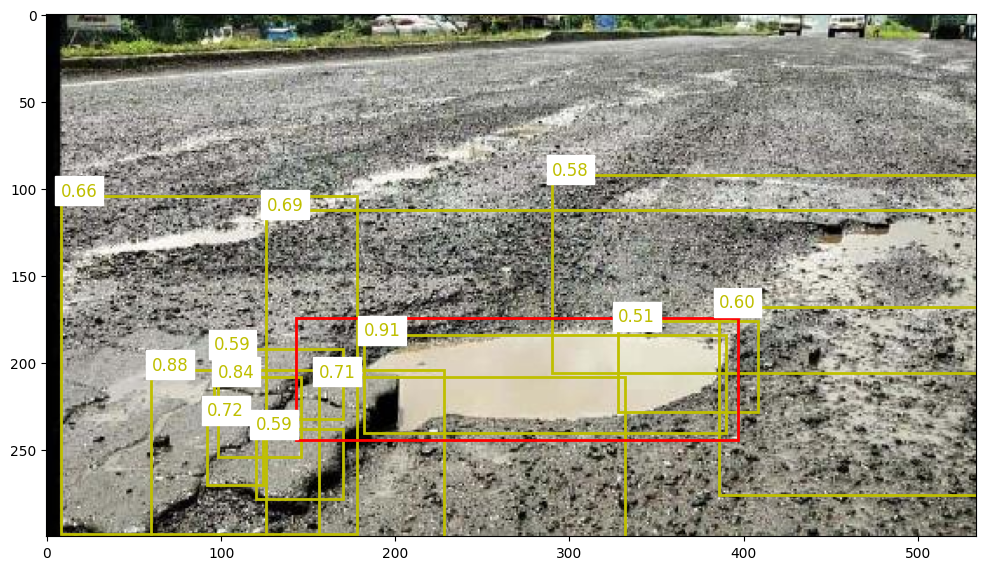

In [19]:
def visualize_detections_and_ground_truths(image_path, detections, ground_truths):

    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    ax = plt.gca()

    # Plot detections
    for det in detections:
        x_min, y_min, x_max, y_max = det['bbox']
        width, height = x_max - x_min, y_max - y_min
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='y', facecolor='none')
        ax.add_patch(rect)
        plt.text(x_min, y_min, f"{det['score']:.2f}", color='y', fontsize=12, backgroundcolor='white')

    # Plot ground truths
    for gt_bbox in ground_truths:
        x_min, y_min, x_max, y_max = gt_bbox
        width, height = x_max - x_min, y_max - y_min
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()


# Define a confidence score threshold
score_threshold = 0.5  # Adjust this value as needed

visualize_detections_and_ground_truths(image_path, final_detections, ground_truths)


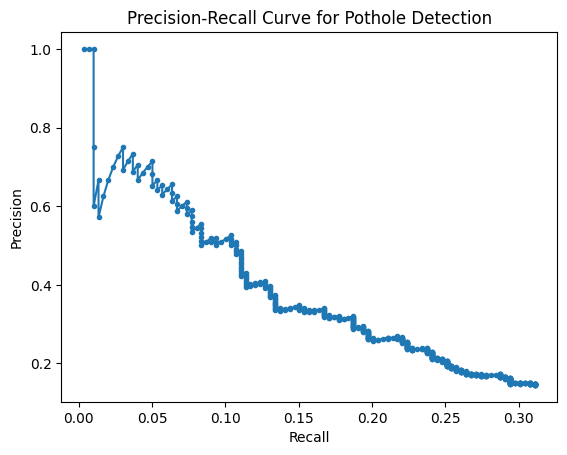

In [21]:

plt.figure()
plt.plot(recalls, precisions, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Pothole Detection')
plt.show()
